# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [3]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="google/gemini-2.5-pro",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [4]:
question = """Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?"""

print(f"Forecasting question: {question}")

Forecasting question: Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?


## Step 3: Generate relevant variables

In [5]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=7)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 7 variables:

  - ai_bubble_bursts_by_2030 (binary): Will there be a rapid, significant, and sustained decline (e.g., >50% drop in a major AI index from its peak) in AI-related market valuations and venture capital funding by the end of 2030?
  - top_5_ai_firms_revenue_2029 (continuous): Combined annual revenue of the top 5 largest publicly traded or privately valued AI-centric companies in 2029.
    Domain: [20.0, 1000.0] billion_usd
  - annual_ai_vc_funding_2029 (continuous): Total global venture capital funding for AI startups in the year 2029.
    Domain: [10.0, 500.0] billion_usd
  - global_recession_before_2030 (binary): Will the IMF declare that at least two G7 economies experienced a recession (two consecutive quarters of negative GDP growth) between 2025 and 2029?
  - top_model_mmlu_score_2028 (continuous): The highest score achieved by any publicly known AI model on the MMLU benchmark by the end of 2028.
    Domain: [85.0, 99.9] percent_score
  - major_ai_regulation

In [6]:
selected_vars = variables

## Step 4: Generate estimates using natural language format

In [7]:
# Generate estimates in natural language format
estimates = est_gen.generate(
    question=question,
    variables=selected_vars,
    num_estimates=30,
)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

Generated 30 estimates:

  P(ai_bubble_bursts_by_2030 = True) = 0.35
  E[top_5_ai_firms_revenue_2029] = 400.0
  E[annual_ai_vc_funding_2029] = 150.0
  P(global_recession_before_2030 = True) = 0.6
  E[top_model_mmlu_score_2028] = 96.0
  P(major_ai_regulation_enacted = True) = 0.75
  E[fortune_500_ai_adoption_2028] = 75.0
  P(ai_bubble_bursts_by_2030 = True | global_recession_before_2030 = True) = 0.55
  P(ai_bubble_bursts_by_2030 = True | top_5_ai_firms_revenue_2029 > 200.0) = 0.8
  P(ai_bubble_bursts_by_2030 = True | fortune_500_ai_adoption_2028 > 50.0) = 0.7
  E[top_5_ai_firms_revenue_2029 | fortune_500_ai_adoption_2028 < 90.0] = 600.0
  E[annual_ai_vc_funding_2029 | top_model_mmlu_score_2028 < 98.0] = 250.0
  P(major_ai_regulation_enacted = True | top_model_mmlu_score_2028 < 98.0) = 0.9
  E[fortune_500_ai_adoption_2028 | top_model_mmlu_score_2028 > 90.0] = 60.0
  E[top_5_ai_firms_revenue_2029 | global_recession_before_2030 = True] = 300.0
  E[annual_ai_vc_funding_2029 | global_recess

## Step 5: Build the maximum entropy distribution

In [ ]:
from calibrated_response.maxent.distribution_builder import DistributionBuilder
from calibrated_response.maxent.multivariate_solver import JAXSolverConfig

# Configure the solver
config = JAXSolverConfig(
    max_bins=10,      # Number of bins for discretization
    maxiter=500,    # Maximum optimization iterations
    tolerance=1e-6,         # Convergence tolerance
    constraint_weight=5.0e1,
    regularization_type='kl_gaussian',  # Regularization to prevent overfitting
    smoothness_weight=6e3,
    verbose=True,
)

# Build the distribution
builder = DistributionBuilder(
    variables=selected_vars,
    estimates=estimates,
    solver_config=config,
)

print(f"Built constraints from {len(builder.constraints)} estimates")

target_var = variables[0]
print(f"Target variable: {target_var.name}")

distribution, info = builder.build(target_variable=target_var.name)

Built constraints from 30 estimates
Target variable: ai_bubble_bursts_by_2030
Initial objective value: 76.874237


In [ ]:


print(f"\nSolver info:")
for key, val in info.items():
    if key not in ['joint_distribution', 'bin_edges_list', 'state', 
                   'bin_edges_list_normalized', 'domains', 'constraint_satisfaction']:
        print(f"  {key}: {val}")
for key, val in info['domains'].items():
    print(f"  Domain for {key}: {val}")
for key, val in info['constraint_satisfaction'].items():
    print(f"  Constraint satisfaction for {key}: {val}")


Solver info:
  n_iterations: 500
  final_loss: 4.259348392486572
  entropy: 8.815393447875977
  converged: False
  error: 0.000650591857265681
  target_variable: ai_bubble_bursts_by_2030
  n_constraints: 30
  n_estimates: 30
  Domain for ai_bubble_bursts_by_2030: (0.0, 1.0)
  Domain for top_5_ai_firms_revenue_2029: (20.0, 1000.0)
  Domain for annual_ai_vc_funding_2029: (10.0, 500.0)
  Domain for global_recession_before_2030: (0.0, 1.0)
  Domain for top_model_mmlu_score_2028: (85.0, 99.9)
  Domain for major_ai_regulation_enacted: (0.0, 1.0)
  Domain for fortune_500_ai_adoption_2028: (20.0, 95.0)
  Constraint satisfaction for c_P_ai_bubble_bursts_by_2030 = True__b6ae5e: {'target': 0.35, 'actual': 0.3838895261287689, 'error': 0.03388952612876894}
  Constraint satisfaction for c_E_top_5_ai_firms_revenue_2029__47e7cd: {'target': 0.3877551020408163, 'actual': 0.38720402121543884, 'error': 0.0005510808253774702}
  Constraint satisfaction for c_E_annual_ai_vc_funding_2029__bbf36a: {'target': 

## Step 6: Visualize the distribution

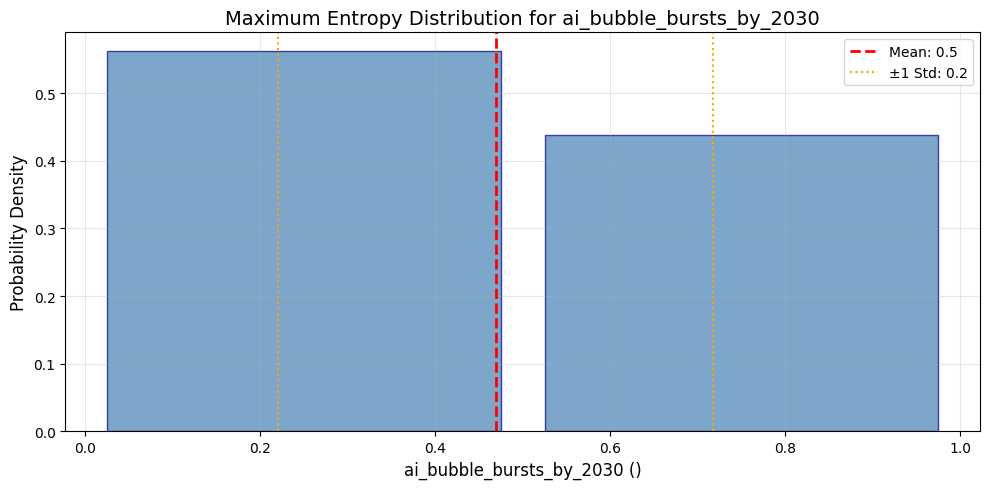


Statistics:
  Mean: 0.47
  Std Dev: 0.25
  90% CI: [0.06, 0.88]


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))

bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]
probs = np.array(distribution.bin_probabilities)

ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
ax.set_xlabel(f"{target_var.name} ({getattr(target_var, 'unit', '')})", fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title(f'Maximum Entropy Distribution for {target_var.name}', fontsize=14)
ax.grid(True, alpha=0.3)

# Add statistics
mean = np.sum(probs * bin_centers)
variance = np.sum(probs * (bin_centers - mean) ** 2)
std = np.sqrt(variance)

ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std: {std:.1f}')
ax.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean: {mean:.2f}")
print(f"  Std Dev: {std:.2f}")
print(f"  90% CI: [{mean - 1.645*std:.2f}, {mean + 1.645*std:.2f}]")

## Step 7: Get all marginal distributions

In [14]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 6 variables:
  ai_bubble_bursts_by_2030: mean = 0.47, bins = 2
  top_companies_revenue_growth: mean = 33.98, bins = 10
  fortune_500_ai_adoption: mean = 78.34, bins = 10
  global_recession_occurs: mean = 0.56, bins = 2
  net_job_displacement_by_ai: mean = 80.85, bins = 10
  ai_compute_energy_consumption: mean = 919.67, bins = 10


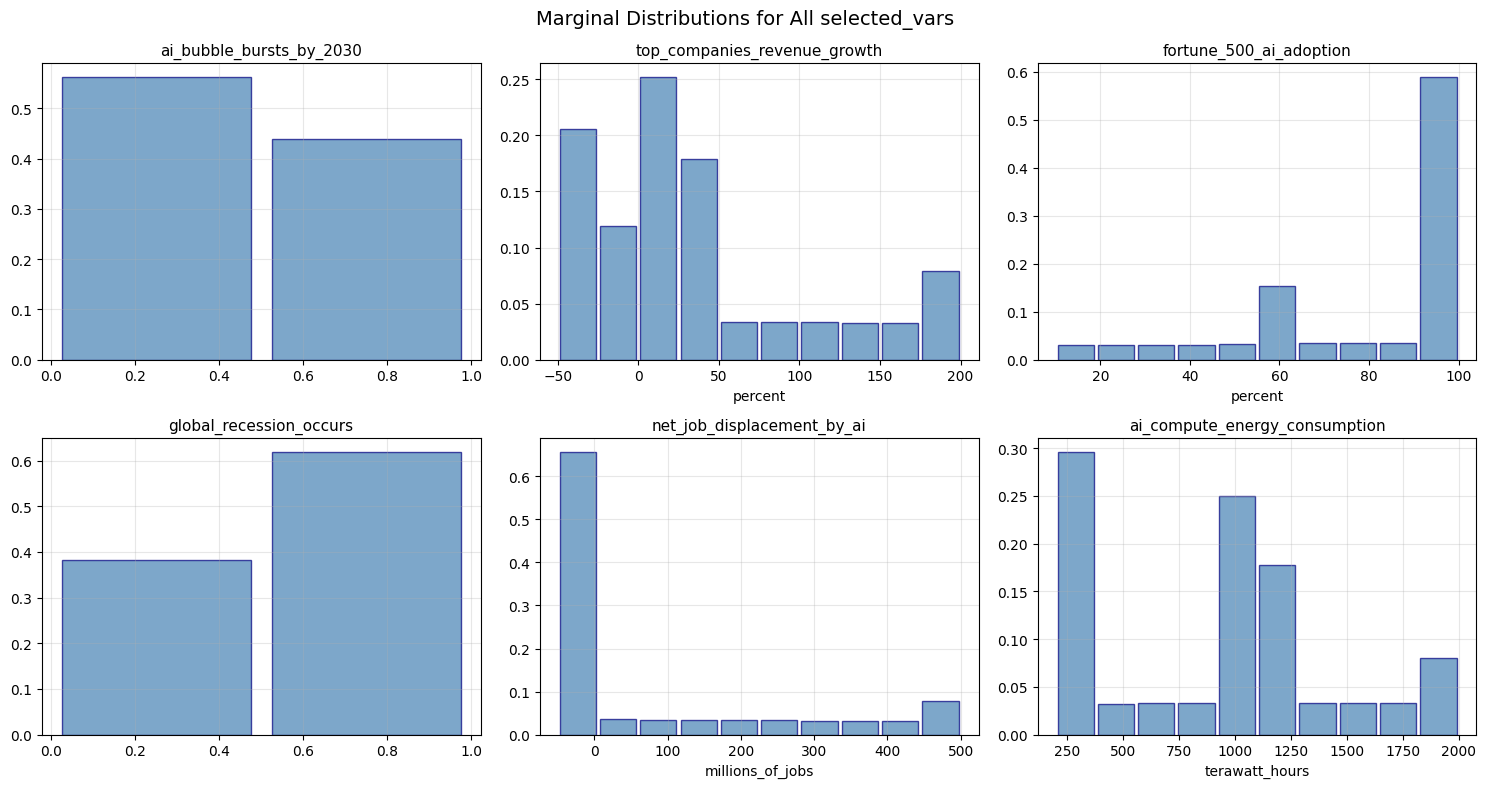

In [15]:
# Plot all marginals in a grid
n_vars = len(selected_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All selected_vars', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

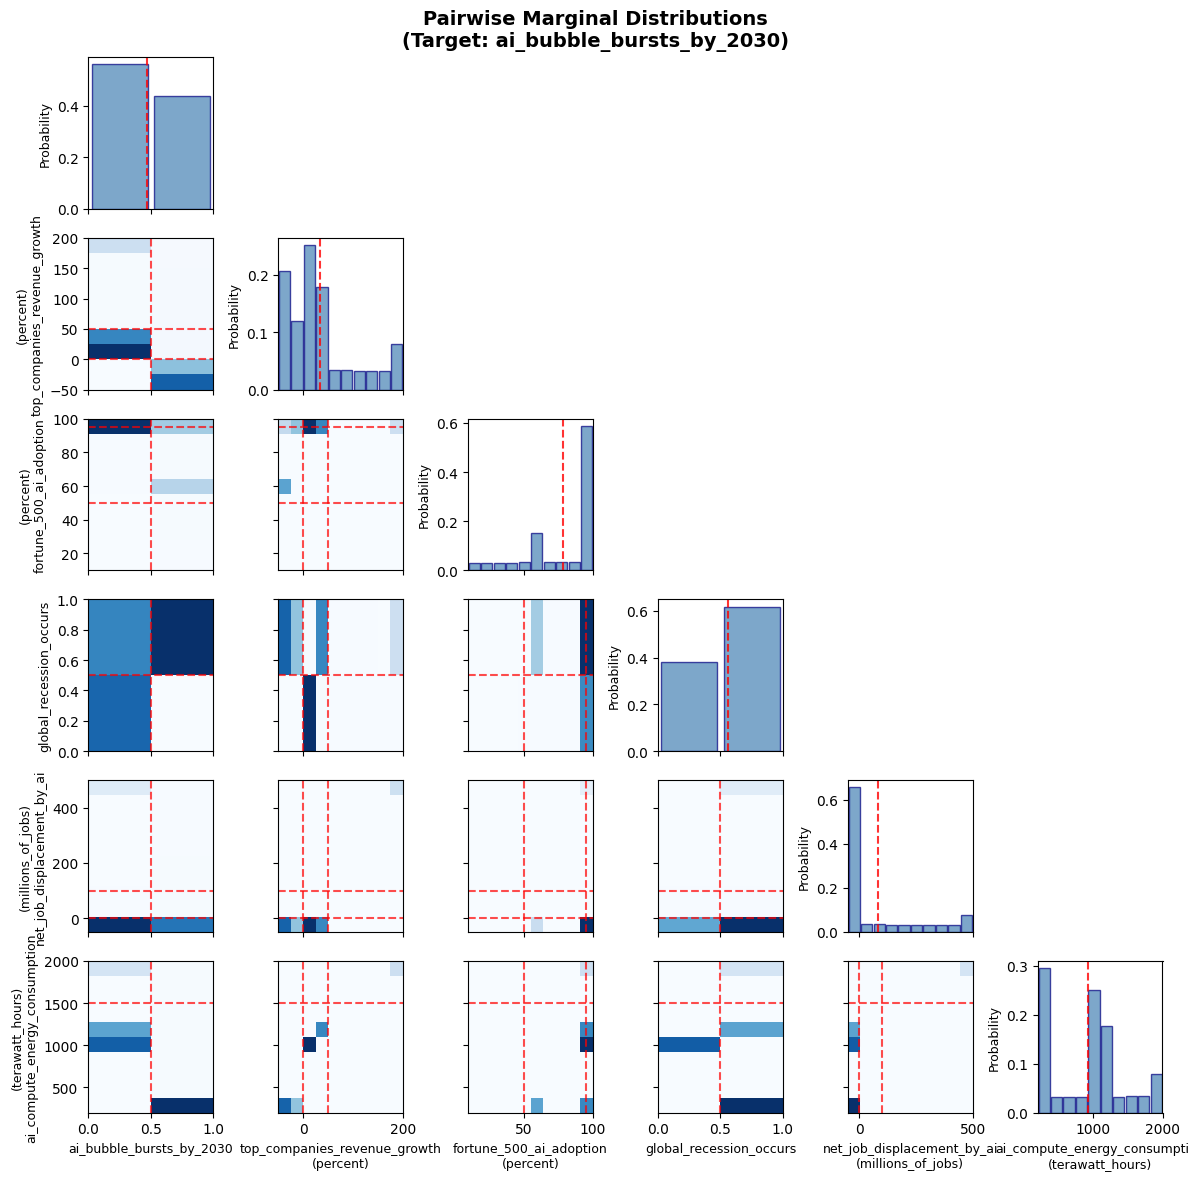

In [16]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=selected_vars,
    target_variable=target_var.name,
    constraints=builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()